In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.layers import LSTM
from sklearn.base import BaseEstimator, RegressorMixin
from keras.models import Sequential
from keras.layers import GRU, LSTM, Dense, Dropout
from keras.optimizers import Adam
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler

In [2]:
train = pd.read_csv('rainfall_train.csv')
test = pd.read_csv('rainfall_test.csv')

train = train.drop('Unnamed: 0', axis=1)
train.columns = ['fc_year','fc_month','fc_day','fc_hour','stn4contest','dh','ef_year','ef_month','ef_day','ef_hour','v01','v02','v03','v04','v05','v06','v07','v08','v09','vv','class_interval']

test = test.drop('Unnamed: 0', axis=1)
test.columns = ['fc_year','fc_month','fc_day','fc_hour','stn4contest','dh','ef_year','ef_month','ef_day','ef_hour','v01','v02','v03','v04','v05','v06','v07','v08','v09','class_interval']

In [3]:
train.head()

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,...,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval
0,A,5,1,9,STN001,3,A,5,1,12,...,0,0,0,0,0,0,0,0,0.0,0
1,A,5,1,9,STN001,6,A,5,1,15,...,0,0,0,0,0,0,0,0,0.0,0
2,A,5,1,9,STN001,9,A,5,1,18,...,0,0,0,0,0,0,0,0,0.0,0
3,A,5,1,9,STN001,12,A,5,1,21,...,0,0,0,0,0,0,0,0,0.0,0
4,A,5,1,9,STN001,15,A,5,2,0,...,0,0,0,0,0,0,0,0,0.0,0


## 결측치 선형보간 데이터셋

In [4]:
nan = train[train.vv == -999]

train_replace = train.replace(-999, np.nan)

train_replace['vv'].interpolate(method='linear', inplace=True)

def classify_class(value):
    if value < 0.1:
        return 0
    elif 0.1 <= value < 0.2:
        return 1
    elif 0.2 <= value < 0.5:
        return 2
    elif 0.5 <= value < 1.0:
        return 3
    elif 1.0 <= value < 2.0:
        return 4
    elif 2.0 <= value < 4.9:
        return 5
    elif 5.0 <= value < 10.0:
        return 6
    elif 10.0 <= value < 20.0:
        return 7
    elif 20.0 <= value < 30.0:
        return 8
    elif 30.0 <= value:
        return 9

class_interpolate = train_replace.iloc[nan.index]['vv'].apply(classify_class)
for idx, v in zip(nan.index, class_interpolate):
    train_replace.loc[idx, 'class_interval'] = v

df = train_replace.iloc[:, :19]

df['ef_year_temp'] = df['ef_year'].replace({'A': '2020', 'B': '2021', 'C': '2022'})
df['ef_datetime'] = pd.to_datetime(df[['ef_year_temp', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
df['weight'] = 1 / df['dh']

for var in ['v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']:
    df[f'{var}_weighted'] = df[var] * df['weight']

weighted_df = df.groupby(['stn4contest', 'ef_datetime']).apply(
    lambda x: pd.Series({
        'v01': np.average(x['v01'], weights=x['weight']),
        'v02': np.average(x['v02'], weights=x['weight']),
        'v03': np.average(x['v03'], weights=x['weight']),
        'v04': np.average(x['v04'], weights=x['weight']),
        'v05': np.average(x['v05'], weights=x['weight']),
        'v06': np.average(x['v06'], weights=x['weight']),
        'v07': np.average(x['v07'], weights=x['weight']),
        'v08': np.average(x['v08'], weights=x['weight']),
        'v09': np.average(x['v09'], weights=x['weight'])
    })
).reset_index()

train_y = train_replace.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour'])[['vv', 'class_interval']].mean().reset_index(drop=True)

weighted_df['vv'] = train_y['vv']
weighted_df['class_interval'] = train_y['class_interval']
weighted_df = weighted_df.astype({'class_interval': 'int'})

weighted_df['year'] = weighted_df['ef_datetime'].dt.year
weighted_df['month'] = weighted_df['ef_datetime'].dt.month
weighted_df['day'] = weighted_df['ef_datetime'].dt.day
weighted_df['hour'] = weighted_df['ef_datetime'].dt.hour

encoder = LabelEncoder()
stn_label = encoder.fit_transform(weighted_df['stn4contest'])
weighted_df['stn4contest'] = stn_label
weighted_df = weighted_df.drop(columns=['ef_datetime'])

data = weighted_df

## 결측치 월별 평균보간 데이터셋

## 주기적 특성 변환 X 

In [5]:
features = data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv']

train_data = data[data['stn4contest'] <= 15]
test_data = data[data['stn4contest'] > 15]

X_train = train_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_train = train_data['vv']

X_test = test_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_test = test_data['vv']

In [6]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [7]:
# GRU 모델 정의
model = Sequential()
model.add(GRU(50, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# 모델 컴파일 (손실 함수를 MAE로 변경)
model.compile(optimizer=Adam(), loss='mean_absolute_error')

In [8]:
# 데이터를 3D 형태로 변환 (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [9]:
# 모델 학습
model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, verbose=1)

# 모델 평가
y_pred_scaled = model.predict(X_test_scaled)

# 예측 값과 실제 값을 원래 스케일로 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled)

# 평가 지표 계산
mae = mean_absolute_error(y_test, y_pred)
print(f'MAE: {mae}')

Epoch 1/10
1950/1950 [==============================] - 48s 20ms/step - loss: 0.0041
Epoch 2/10
1950/1950 [==============================] - 40s 20ms/step - loss: 0.0035
Epoch 3/10
1950/1950 [==============================] - 41s 21ms/step - loss: 0.0034
Epoch 4/10
1950/1950 [==============================] - 41s 21ms/step - loss: 0.0034
Epoch 5/10
1950/1950 [==============================] - 45s 23ms/step - loss: 0.0034
Epoch 6/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 7/10
1950/1950 [==============================] - 44s 23ms/step - loss: 0.0034
Epoch 8/10
1950/1950 [==============================] - 42s 22ms/step - loss: 0.0034
Epoch 9/10
1950/1950 [==============================] - 40s 21ms/step - loss: 0.0034
Epoch 10/10
488/488 [==============================] - 10s 15ms/step
MAE: 0.6491339414785463


In [11]:
model.save('gru_model.h5')

In [29]:
# 예측값과 실제값 스케일 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)

# MSE 계산
mse = mean_squared_error(y_test, y_pred)

# R² 계산
r2 = r2_score(y_test, y_pred)

In [30]:
print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.4843              
MAE       0.6447              
MSE       12.1404             
R²        0.3279              


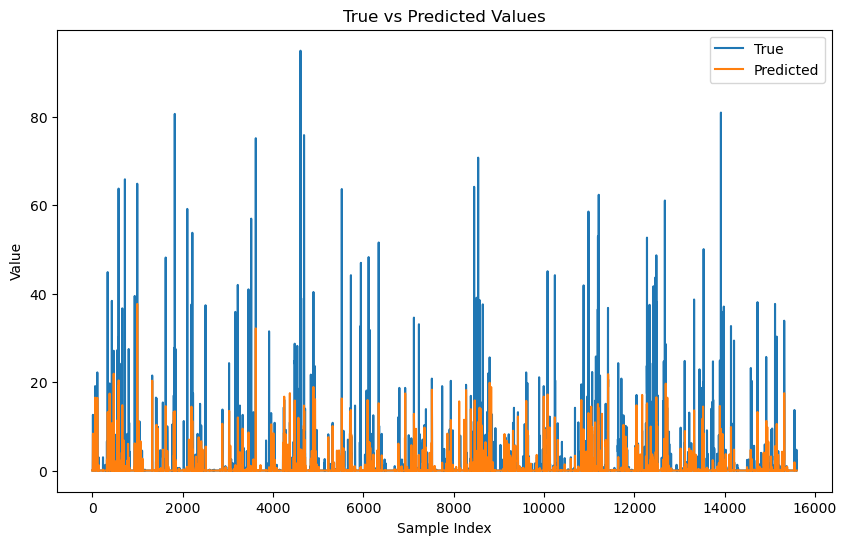

In [31]:
# 예측값과 실제값 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

In [32]:
# GRU 모델 정의
model_comp = Sequential()
model_comp.add(GRU(units=100, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
model_comp.add(Dropout(0.2))  # 드롭아웃 추가
model_comp.add(GRU(units=100, return_sequences=True))
model_comp.add(Dropout(0.2))  # 드롭아웃 추가
model_comp.add(GRU(units=100))
model_comp.add(Dropout(0.2))  # 드롭아웃 추가
model_comp.add(Dense(50, activation='relu'))  # Dense 레이어 추가
model_comp.add(Dense(1))

# 모델 컴파일
model_comp.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# 모델 학습
history_comp = model_comp.fit(X_train_scaled, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)


Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 28s 15ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 2/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 3/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 5/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 19s 12ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - loss: 0.0035 - val_loss: 0.0036
Epoch 7/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 8/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 22s 14ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 9/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 10/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 11/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 12/50
1560/15

NameError: name 'history' is not defined

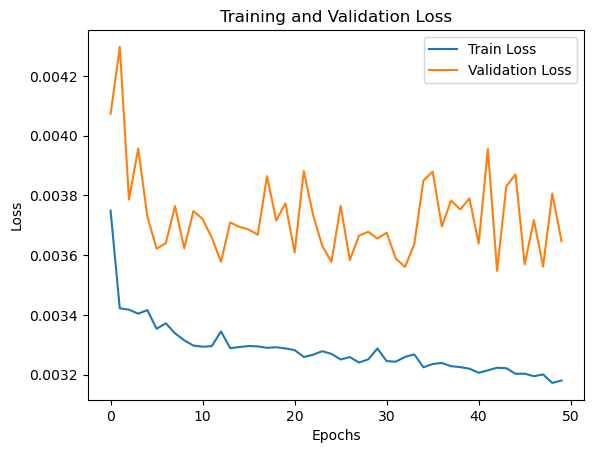

In [33]:
# 학습 과정 시각화
plt.plot(history_comp.history['loss'], label='Train Loss')
plt.plot(history_comp.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0034
Test Loss: 0.003224567975848913
488/488 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


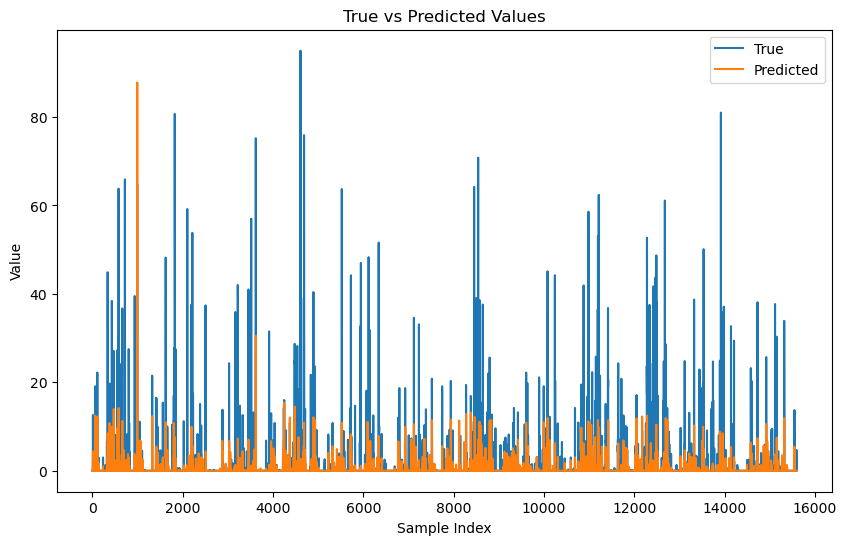

In [36]:
# 모델 평가
loss = model_comp.evaluate(X_test_scaled, y_test_scaled, verbose=1)
print(f'Test Loss: {loss}')

# 예측
y_pred_scaled = model_comp.predict(X_test_scaled)

# 스케일링 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test, label='True')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.show()

In [38]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.6317              
MAE       0.6552              
MSE       13.1892             
R²        0.2699              


### GridSearchCV 하이퍼파라미터 튜닝

In [46]:
# 모델을 생성하는 함수 정의
def create_model(gru_units=50, learning_rate=0.001, dropout_rate=0.2):
    model = Sequential()
    model.add(GRU(units=gru_units, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=gru_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

# 사용자 정의 래퍼 클래스 정의
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, gru_units=50, learning_rate=0.001, dropout_rate=0.2, epochs=50, batch_size=32, verbose=0):
        self.gru_units = gru_units
        self.learning_rate = learning_rate
        self.dropout_rate = dropout_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def fit(self, X, y):
        self.model = create_model(gru_units=self.gru_units, learning_rate=self.learning_rate, dropout_rate=self.dropout_rate)
        self.history = self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, validation_split=0.2)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_squared_error(y, y_pred)

# 하이퍼파라미터 그리드 정의
param_grid = {
    'gru_units': [50, 100, 150],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32, 64],
    'dropout_rate': [0.2, 0.3],
    'epochs': [50]  # 에포크 수는 고정
}

# k-fold 교차 검증 설정
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# GridSearchCV 초기화 및 실행
model = KerasRegressorWrapper()
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold, verbose=1)
grid_result = grid.fit(X_train_scaled, y_train_scaled)

# 최적의 하이퍼파라미터 출력
print(f"Best Hyperparameters: {grid_result.best_params_}")
print(f"Best Score (MSE): {-grid_result.best_score_}")

# 최적의 모델 평가
best_model = grid_result.best_estimator_.model
y_pred_scaled = best_model.predict(X_test_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test = y_scaler.inverse_transform(y_test_scaled)

# 평가 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# 결과 출력
print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


390/390 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


KeyboardInterrupt: 

# GRU + XGboost

In [52]:
data= weighted_df
data.head()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval,year,month,day,hour
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,12
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,15
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,18
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,21
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,2,0


In [53]:
# 주기적 특성 변환
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_sin'] = np.sin(2 * np.pi * data['day'] / 31)
data['day_cos'] = np.cos(2 * np.pi * data['day'] / 31)
data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

In [55]:
features = data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv']

train_data = data[data['stn4contest'] <= 15]
test_data = data[data['stn4contest'] > 15]

X_train = train_data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_train = train_data['vv']
X_test = test_data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_test = test_data['vv']

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

In [56]:
def create_gru_model(input_shape):
    model = Sequential()
    model.add(GRU(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(GRU(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')
    return model

# GRU 모델 생성
gru_model = create_gru_model((X_train_3d.shape[1], X_train_3d.shape[2]))

# GRU 모델 학습
gru_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0100 - val_loss: 0.0039
Epoch 2/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 3/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 4/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 5/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 8/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - val_loss: 0.0040
Epoch 9/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 10/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 11/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 12/50
1560/1560 ━━━━━━━━━━━━━━━━━━━

In [58]:
!pip install xgboost

   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/99.8 MB 682.7 kB/s eta 0:02:27
   ---------------------------------------- 0.1/99.8 MB 1.2 MB/s eta 0:01:27
   ---------------------------------------- 0.2/99.8 MB 1.7 MB/s eta 0:01:01
   ---------------------------------------- 0.2/99.8 MB 1.7 MB/s eta 0:01:00
   ---------------------------------------- 0.4/99.8 MB 1.7 MB/s eta 0:00:58
   ---------------------------------------- 0.5/99.8 MB 1.8 MB/s eta 0:00:57
   ---------------------------------------- 0.5/99.8 MB 1.9 MB/s eta 0:00:54
   ---------------------------------------- 0.7/99.8 MB 1.9 MB/s eta 0:00:52
   ---------------------------------------- 0.8/99.8 MB 2.0 MB/s eta 0:00:49
   ---------------------------------------- 0.9/99.8 MB 2.1 MB/s eta 0:00:47
   ---------------------------------------- 1.0/99.8 MB 2.1 MB/s eta 0:00:46
   ---------------------------------------- 1.1/99.8 MB 2.1 MB/s eta 0:00:47
   -

In [59]:
# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.01, max_depth=5, n_estimators=1000)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=50, verbose=True)

[0]	validation_0-rmse:4.23414
[1]	validation_0-rmse:4.21852
[2]	validation_0-rmse:4.20306
[3]	validation_0-rmse:4.18782
[4]	validation_0-rmse:4.17276
[5]	validation_0-rmse:4.15795
[6]	validation_0-rmse:4.14339
[7]	validation_0-rmse:4.12907
[8]	validation_0-rmse:4.11476
[9]	validation_0-rmse:4.10089
[10]	validation_0-rmse:4.08723
[11]	validation_0-rmse:4.07383
[12]	validation_0-rmse:4.06069
[13]	validation_0-rmse:4.04774
[14]	validation_0-rmse:4.03553
[15]	validation_0-rmse:4.02304
[16]	validation_0-rmse:4.01134
[17]	validation_0-rmse:3.99995
[18]	validation_0-rmse:3.98811
[19]	validation_0-rmse:3.97690
[20]	validation_0-rmse:3.96540
[21]	validation_0-rmse:3.95388
[22]	validation_0-rmse:3.94288
[23]	validation_0-rmse:3.93179
[24]	validation_0-rmse:3.92153
[25]	validation_0-rmse:3.91091
[26]	validation_0-rmse:3.90035
[27]	validation_0-rmse:3.89001
[28]	validation_0-rmse:3.87985
[29]	validation_0-rmse:3.86967
[30]	validation_0-rmse:3.86052
[31]	validation_0-rmse:3.85124


C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-rmse:3.84162
[33]	validation_0-rmse:3.83229
[34]	validation_0-rmse:3.82314
[35]	validation_0-rmse:3.81393
[36]	validation_0-rmse:3.80525
[37]	validation_0-rmse:3.79722
[38]	validation_0-rmse:3.78894
[39]	validation_0-rmse:3.78041
[40]	validation_0-rmse:3.77188
[41]	validation_0-rmse:3.76395
[42]	validation_0-rmse:3.75597
[43]	validation_0-rmse:3.74852
[44]	validation_0-rmse:3.74079
[45]	validation_0-rmse:3.73294
[46]	validation_0-rmse:3.72583
[47]	validation_0-rmse:3.71764
[48]	validation_0-rmse:3.71103
[49]	validation_0-rmse:3.70326
[50]	validation_0-rmse:3.69637
[51]	validation_0-rmse:3.68926
[52]	validation_0-rmse:3.68175
[53]	validation_0-rmse:3.67497
[54]	validation_0-rmse:3.66818
[55]	validation_0-rmse:3.66226
[56]	validation_0-rmse:3.65537
[57]	validation_0-rmse:3.64884
[58]	validation_0-rmse:3.64265
[59]	validation_0-rmse:3.63657
[60]	validation_0-rmse:3.63057
[61]	validation_0-rmse:3.62487
[62]	validation_0-rmse:3.61919
[63]	validation_0-rmse:3.61341
[64]	val

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [60]:
# GRU 모델 예측
gru_pred_scaled = gru_model.predict(X_test_3d)
gru_pred = y_scaler.inverse_transform(gru_pred_scaled)

# XGBoost 모델 예측
xgb_pred = xgb_model.predict(X_test_scaled)

# 앙상블 예측 (평균)
ensemble_pred = (gru_pred.flatten() + xgb_pred) / 2

rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
mse = mean_squared_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

# 결과 출력
print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ensemble Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.3903              
MAE       0.7326              
MSE       11.4942             
R²        0.3637              


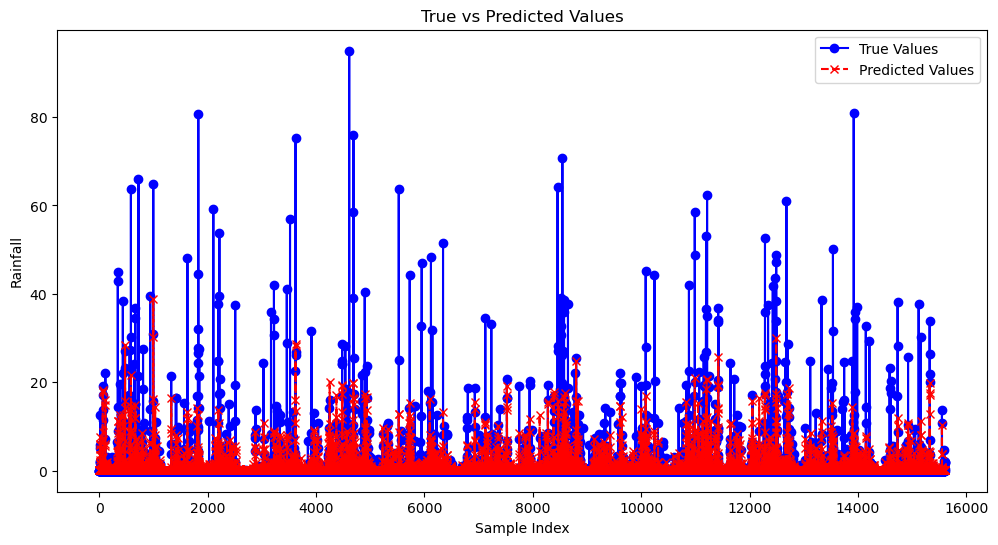

In [61]:
# 예측값과 실제값 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [62]:
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')  # MAE 사용
    return model

# LSTM 모델 생성
lstm_model = create_lstm_model((X_train_3d.shape[1], X_train_3d.shape[2]))

# LSTM 모델 학습
lstm_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0050 - val_loss: 0.0038
Epoch 2/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0035 - val_loss: 0.0037
Epoch 3/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 4/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 5/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 6/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 7/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0032 - val_loss: 0.0036
Epoch 8/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 9/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0032 - val_loss: 0.0037
Epoch 10/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 11/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 12/50
1560/1560 ━━━━━━━━━━━━━━━━━━━

In [63]:
# LSTM 모델 예측
lstm_pred_scaled = lstm_model.predict(X_test_3d)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)

# 앙상블 예측 (평균)
ensemble_pred = (gru_pred.flatten() + lstm_pred.flatten() + xgb_pred) / 3

# 평가 지표 계산
rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
mse = mean_squared_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

# 결과 출력
print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ensemble Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.4470              
MAE       0.6963              
MSE       11.8816             
R²        0.3423              


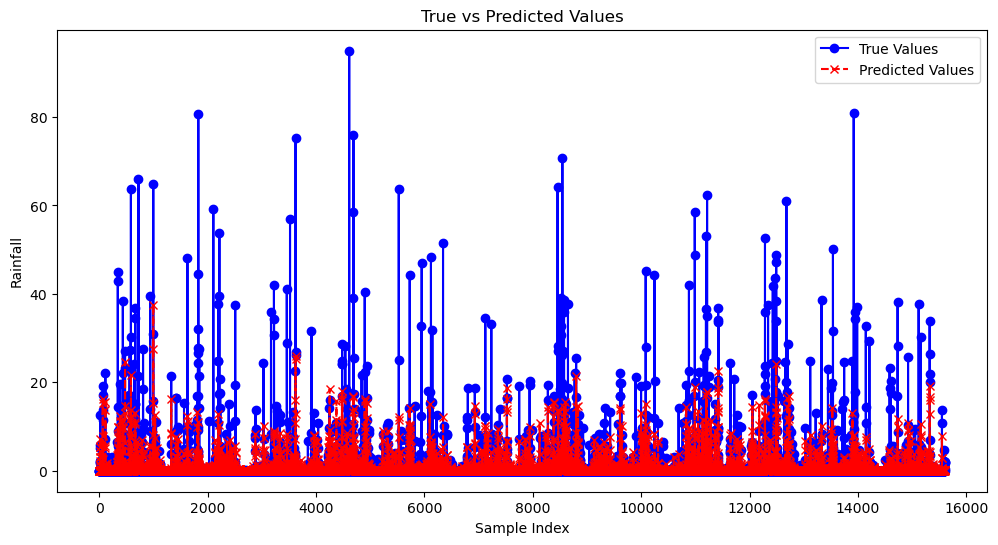

In [64]:
# 예측값과 실제값 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

### 하이퍼 파라미터 튜닝

In [19]:
class KerasRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, model_type='GRU', units=50, dropout_rate=0.2, learning_rate=0.001, epochs=50, batch_size=32, verbose=0):
        self.model_type = model_type
        self.units = units
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.verbose = verbose
        self.model = None

    def build_model(self):
        model = Sequential()
        if self.model_type == 'GRU':
            model.add(GRU(units=self.units, return_sequences=True, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
            model.add(Dropout(self.dropout_rate))
            model.add(GRU(units=self.units))
        elif self.model_type == 'LSTM':
            model.add(LSTM(units=self.units, return_sequences=True, input_shape=(X_train_3d.shape[1], X_train_3d.shape[2])))
            model.add(Dropout(self.dropout_rate))
            model.add(LSTM(units=self.units))
        model.add(Dropout(self.dropout_rate))
        model.add(Dense(1))
        model.compile(optimizer=Adam(learning_rate=self.learning_rate), loss='mean_absolute_error')
        return model

    def fit(self, X, y):
        self.model = self.build_model()
        self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=self.verbose, validation_split=0.2)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        y_pred = self.predict(X)
        return -mean_absolute_error(y, y_pred)

In [66]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'units': [50, 100],
    'dropout_rate': [0.2],
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [50]
}

# GRU 모델 하이퍼파라미터 튜닝
gru_model = KerasRegressorWrapper(model_type='GRU')
gru_grid = GridSearchCV(estimator=gru_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
gru_grid_result = gru_grid.fit(X_train_3d, y_train_scaled)

# LSTM 모델 하이퍼파라미터 튜닝
lstm_model = KerasRegressorWrapper(model_type='LSTM')
lstm_grid = GridSearchCV(estimator=lstm_model, param_grid=param_grid, scoring='neg_mean_absolute_error', cv=3, verbose=1)
lstm_grid_result = lstm_grid.fit(X_train_3d, y_train_scaled)

# 최적의 하이퍼파라미터 출력
print(f"Best GRU Hyperparameters: {gru_grid_result.best_params_}")
print(f"Best GRU Score (MAE): {-gru_grid_result.best_score_}")
print(f"Best LSTM Hyperparameters: {lstm_grid_result.best_params_}")
print(f"Best LSTM Score (MAE): {-lstm_grid_result.best_score_}")

# 최적의 모델 평가
best_gru_model = gru_grid_result.best_estimator_.model
best_lstm_model = lstm_grid_result.best_estimator_.model

gru_pred_scaled = best_gru_model.predict(X_test_3d)
gru_pred = y_scaler.inverse_transform(gru_pred_scaled)

lstm_pred_scaled = best_lstm_model.predict(X_test_3d)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)

xgb_pred = xgb_model.predict(X_test_scaled)


Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 815us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 791us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 762us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 830us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 887us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 874us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 931us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 787us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 956us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 890us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 848us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting 3 folds for each of 8 candidates, totalling 24 fits
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 816us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 827us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 707us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 772us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 845us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 803us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 714us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 698us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 750us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 847us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 808us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 796us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 757us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 712us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 766us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 767us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 788us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 694us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 2s 714us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 891us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 868us/step


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Best GRU Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 50}
Best GRU Score (MAE): 0.0032898530959574236
Best LSTM Hyperparameters: {'batch_size': 32, 'dropout_rate': 0.2, 'epochs': 50, 'learning_rate': 0.001, 'units': 100}
Best LSTM Score (MAE): 0.003262305295980215
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [67]:
def create_gru_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

def create_lstm_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

# 최적 하이퍼파라미터로 GRU 모델 학습
gru_model = create_gru_model((X_train_3d.shape[1], X_train_3d.shape[2]), units=50, dropout_rate=0.2, learning_rate=0.001)
gru_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

# 최적 하이퍼파라미터로 LSTM 모델 학습
lstm_model = create_lstm_model((X_train_3d.shape[1], X_train_3d.shape[2]), units=100, dropout_rate=0.2, learning_rate=0.001)
lstm_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0104 - val_loss: 0.0043
Epoch 2/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0036 - val_loss: 0.0038
Epoch 3/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 4/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 5/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 6/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0038
Epoch 8/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 9/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0034 - val_loss: 0.0037
Epoch 10/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0032 - val_loss: 0.0038
Epoch 11/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0033 - val_loss: 0.0037
Epoch 12/50
1560/1560 ━━━━━━━━━━━━━━━━━━━

In [68]:
gru_pred_scaled = gru_model.predict(X_test_3d)
gru_pred = y_scaler.inverse_transform(gru_pred_scaled)
lstm_pred_scaled = lstm_model.predict(X_test_3d)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)
xgb_pred = xgb_model.predict(X_test_scaled)

ensemble_pred = (gru_pred.flatten() + lstm_pred.flatten() + xgb_pred) / 3

rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
mae = mean_absolute_error(y_test, ensemble_pred)
mse = mean_squared_error(y_test, ensemble_pred)
r2 = r2_score(y_test, ensemble_pred)

print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
488/488 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Ensemble Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.3928              
MAE       0.6765              
MSE       11.5114             
R²        0.3628              


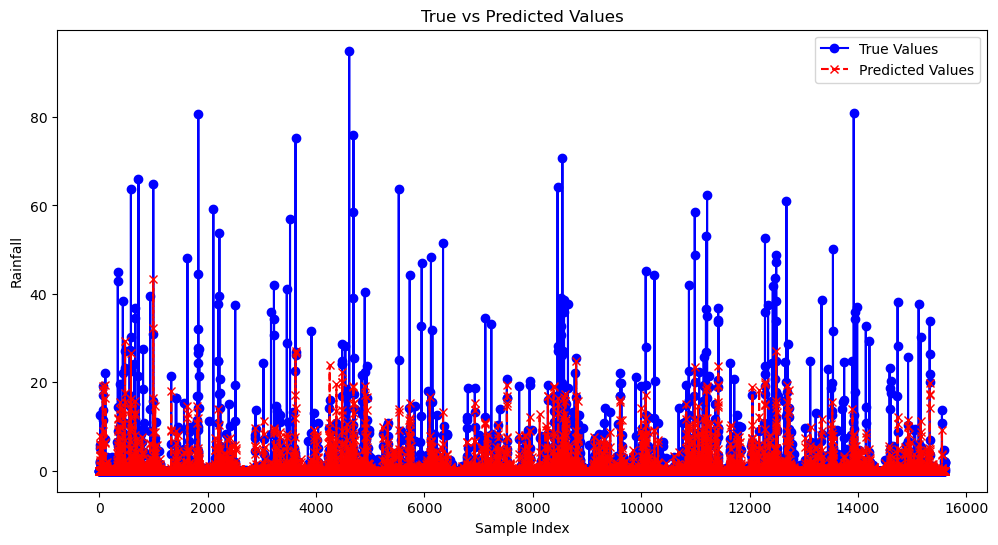

In [70]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

## VV 로그 변환 후 앙상블 (GRU+LSTM+XGBoost)

In [72]:
# 로그 변환 적용
data['vv_log'] = np.log1p(data['vv'])

# 필요한 열 선택 (year 변수 포함)
features = data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv_log']

# 관측소 번호에 따라 훈련 및 테스트 데이터 분리
train_data = data[data['stn4contest'] <= 15]
test_data = data[data['stn4contest'] > 15]

X_train = train_data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_train = train_data['vv_log']
X_test = test_data[['stn4contest', 'year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'hour_sin', 'hour_cos', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_test = test_data['vv_log']

# 데이터 스케일링
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# GRU 및 LSTM 모델에 맞게 3차원으로 변환 (samples, timesteps, features)
X_train_3d = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_3d = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# 타겟 데이터 스케일링
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1))

def create_gru_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model

def create_lstm_model(input_shape, units, dropout_rate, learning_rate):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_absolute_error')
    return model
# GRU 모델 학습
gru_model = create_gru_model((X_train_3d.shape[1], X_train_3d.shape[2]), units=50, dropout_rate=0.2, learning_rate=0.001)
gru_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
# LSTM 모델 학습
lstm_model = create_lstm_model((X_train_3d.shape[1], X_train_3d.shape[2]), units=100, dropout_rate=0.2, learning_rate=0.001)
lstm_model.fit(X_train_3d, y_train_scaled, epochs=50, batch_size=32, validation_split=0.2, verbose=1)
# XGBoost 모델 생성 및 학습
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', learning_rate=0.01, max_depth=5, n_estimators=1000)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], early_stopping_rounds=50, verbose=True)

# GRU 모델 예측
gru_pred_scaled = gru_model.predict(X_test_3d)
gru_pred = y_scaler.inverse_transform(gru_pred_scaled)

# LSTM 모델 예측
lstm_pred_scaled = lstm_model.predict(X_test_3d)
lstm_pred = y_scaler.inverse_transform(lstm_pred_scaled)

# XGBoost 모델 예측
xgb_pred = xgb_model.predict(X_test_scaled)

# 앙상블 예측 (평균)
ensemble_pred1 = (gru_pred.flatten() + lstm_pred.flatten() + xgb_pred) / 3

rmse1 = np.sqrt(mean_squared_error(y_test, ensemble_pred1))
mae1 = mean_absolute_error(y_test, ensemble_pred1)
mse1 = mean_squared_error(y_test, ensemble_pred1)
r21 = r2_score(y_test, ensemble_pred1)

# 결과 출력
print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse1:<20.4f}")
print(f"{'MAE':<10}{mae1:<20.4f}")
print(f"{'MSE':<10}{mse1:<20.4f}")
print(f"{'R²':<10}{r21:<20.4f}")

Epoch 1/50


C:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1560/1560 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0352 - val_loss: 0.0251
Epoch 2/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0269 - val_loss: 0.0248
Epoch 3/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0262 - val_loss: 0.0246
Epoch 4/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0258 - val_loss: 0.0246
Epoch 5/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0257 - val_loss: 0.0247
Epoch 6/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0249 - val_loss: 0.0245
Epoch 7/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0249 - val_loss: 0.0249
Epoch 8/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 9/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0250 - val_loss: 0.0241
Epoch 10/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0241 - val_loss: 0.0242
Epoch 11/50
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 12/50
1560/1560 ━━━━━━━━━━━━━━━━━━━

C:\Users\user\anaconda3\Lib\site-packages\xgboost\sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[39]	validation_0-rmse:0.48342
[40]	validation_0-rmse:0.48156
[41]	validation_0-rmse:0.47976
[42]	validation_0-rmse:0.47797
[43]	validation_0-rmse:0.47620
[44]	validation_0-rmse:0.47444
[45]	validation_0-rmse:0.47273
[46]	validation_0-rmse:0.47104
[47]	validation_0-rmse:0.46938
[48]	validation_0-rmse:0.46773
[49]	validation_0-rmse:0.46613
[50]	validation_0-rmse:0.46456
[51]	validation_0-rmse:0.46301
[52]	validation_0-rmse:0.46149
[53]	validation_0-rmse:0.45998
[54]	validation_0-rmse:0.45850
[55]	validation_0-rmse:0.45705
[56]	validation_0-rmse:0.45561
[57]	validation_0-rmse:0.45420
[58]	validation_0-rmse:0.45281
[59]	validation_0-rmse:0.45146
[60]	validation_0-rmse:0.45013
[61]	validation_0-rmse:0.44881
[62]	validation_0-rmse:0.44753
[63]	validation_0-rmse:0.44628
[64]	validation_0-rmse:0.44502
[65]	validation_0-rmse:0.44379
[66]	validation_0-rmse:0.44257
[67]	validation_0-rmse:0.44140
[68]	validation_0-rmse:0.44023
[69]	validation_0-rmse:0.43909
[70]	validation_0-rmse:0.43799
[71]	val

In [79]:
# 실제 값으로 복원 (지수 변환)
y_test_original = np.expm1(y_test.values)
ensemble_pred_original = np.expm1(ensemble_pred1)

# 실제 값으로 복원한 후 성능 지표 계산
rmse_original = np.sqrt(mean_squared_error(y_test_original, ensemble_pred_original))
mae_original = mean_absolute_error(y_test_original, ensemble_pred_original)
mse_original = mean_squared_error(y_test_original, ensemble_pred_original)
r2_original = r2_score(y_test_original, ensemble_pred_original)

# 결과 출력 (실제 값으로 복원한 후)
print(f"Ensemble Model Performance Metrics (Original Scale):")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse_original:<20.4f}")
print(f"{'MAE':<10}{mae_original:<20.4f}")
print(f"{'MSE':<10}{mse_original:<20.4f}")
print(f"{'R²':<10}{r2_original:<20.4f}")

Ensemble Model Performance Metrics (Original Scale):
Metric    Value               
------------------------------
RMSE      3.5245              
MAE       0.6426              
MSE       12.4224             
R²        0.3123              


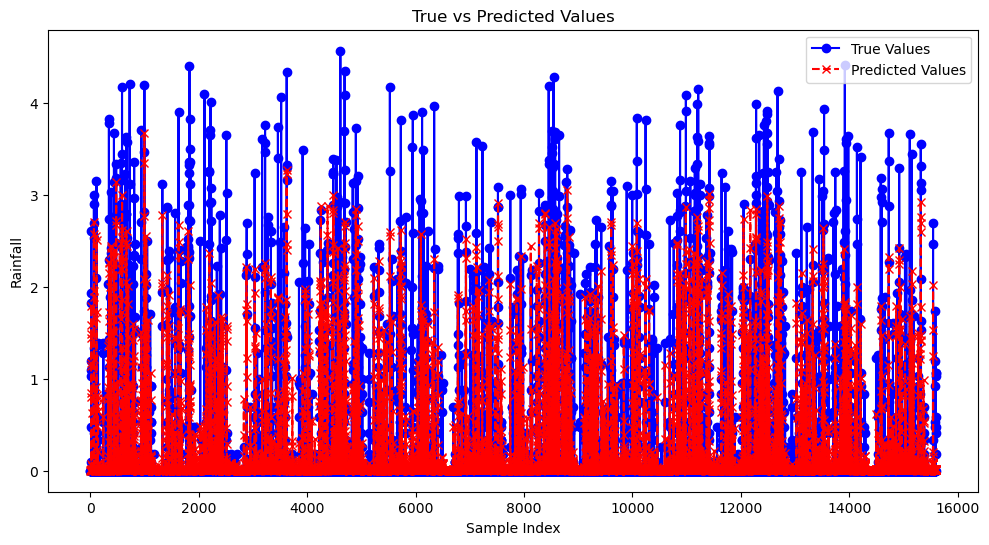

In [73]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred1, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [75]:
ensemble_pred2 = (gru_pred.flatten() + lstm_pred.flatten()) / 2
rmse2 = np.sqrt(mean_squared_error(y_test, ensemble_pred2))
mae2 = mean_absolute_error(y_test, ensemble_pred2)
mse2 = mean_squared_error(y_test, ensemble_pred2)
r22 = r2_score(y_test, ensemble_pred2)

# 결과 출력
print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse2:<20.4f}")
print(f"{'MAE':<10}{mae2:<20.4f}")
print(f"{'MSE':<10}{mse2:<20.4f}")
print(f"{'R²':<10}{r22:<20.4f}")

Ensemble Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      0.3961              
MAE       0.1234              
MSE       0.1569              
R²        0.5446              


In [80]:
# 실제 값으로 복원 (지수 변환)
y_test_original = np.expm1(y_test.values)
ensemble_pred_original = np.expm1(ensemble_pred2)

# 실제 값으로 복원한 후 성능 지표 계산
rmse_original = np.sqrt(mean_squared_error(y_test_original, ensemble_pred_original))
mae_original = mean_absolute_error(y_test_original, ensemble_pred_original)
mse_original = mean_squared_error(y_test_original, ensemble_pred_original)
r2_original = r2_score(y_test_original, ensemble_pred_original)

# 결과 출력 (실제 값으로 복원한 후)
print(f"Ensemble Model Performance Metrics (Original Scale):")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse_original:<20.4f}")
print(f"{'MAE':<10}{mae_original:<20.4f}")
print(f"{'MSE':<10}{mse_original:<20.4f}")
print(f"{'R²':<10}{r2_original:<20.4f}")

Ensemble Model Performance Metrics (Original Scale):
Metric    Value               
------------------------------
RMSE      3.5703              
MAE       0.6401              
MSE       12.7469             
R²        0.2944              


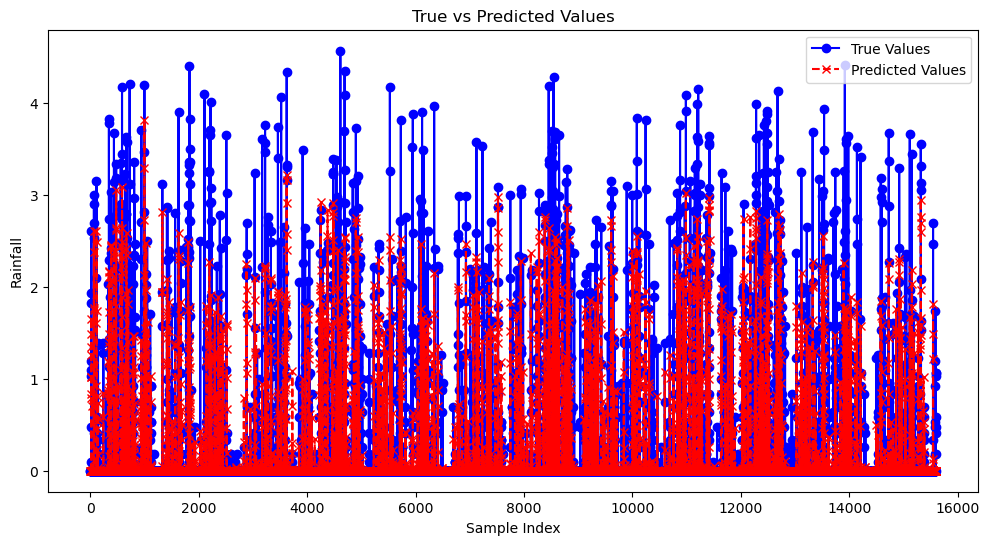

In [76]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred2, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [78]:
ensemble_pred3 = (gru_pred.flatten() + xgb_pred) / 2
rmse3 = np.sqrt(mean_squared_error(y_test, ensemble_pred3))
mae3 = mean_absolute_error(y_test, ensemble_pred3)
mse3 = mean_squared_error(y_test, ensemble_pred3)
r23 = r2_score(y_test, ensemble_pred3)

# 결과 출력
print(f"Ensemble Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse3:<20.4f}")
print(f"{'MAE':<10}{mae3:<20.4f}")
print(f"{'MSE':<10}{mse3:<20.4f}")
print(f"{'R²':<10}{r23:<20.4f}")

Ensemble Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      0.3797              
MAE       0.1363              
MSE       0.1442              
R²        0.5815              


In [81]:
# 실제 값으로 복원 (지수 변환)
y_test_original = np.expm1(y_test.values)
ensemble_pred_original = np.expm1(ensemble_pred3)

# 실제 값으로 복원한 후 성능 지표 계산
rmse_original = np.sqrt(mean_squared_error(y_test_original, ensemble_pred_original))
mae_original = mean_absolute_error(y_test_original, ensemble_pred_original)
mse_original = mean_squared_error(y_test_original, ensemble_pred_original)
r2_original = r2_score(y_test_original, ensemble_pred_original)

# 결과 출력 (실제 값으로 복원한 후)
print(f"Ensemble Model Performance Metrics (Original Scale):")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse_original:<20.4f}")
print(f"{'MAE':<10}{mae_original:<20.4f}")
print(f"{'MSE':<10}{mse_original:<20.4f}")
print(f"{'R²':<10}{r2_original:<20.4f}")

Ensemble Model Performance Metrics (Original Scale):
Metric    Value               
------------------------------
RMSE      3.4711              
MAE       0.6463              
MSE       12.0484             
R²        0.3330              


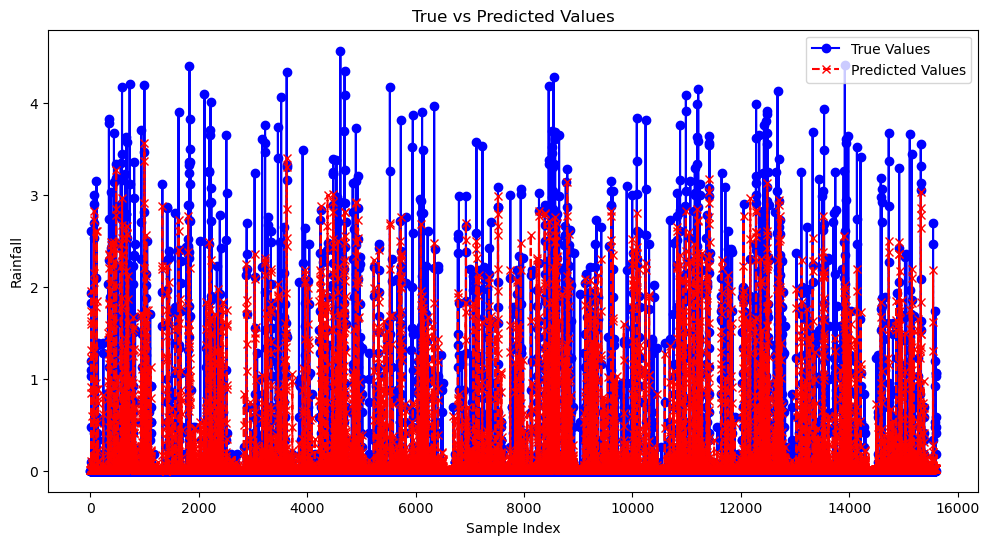

In [82]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='True Values', color='blue', linestyle='-', marker='o')
plt.plot(ensemble_pred3, label='Predicted Values', color='red', linestyle='--', marker='x')
plt.title('True vs Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

In [15]:
features = data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv']

train_data = data[data['stn4contest'] <= 15]
test_data = data[data['stn4contest'] > 15]

X_train = train_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_train = train_data['vv']

X_test = test_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_test = test_data['vv']

In [16]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [17]:
svr_model = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr_model.fit(X_train_scaled, y_train_scaled)

y_pred = svr_model.predict(X_test_scaled)

C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [22]:
rmse = np.sqrt(mean_squared_error(y_test_scaled, y_pred))
mae = mean_absolute_error(y_test_scaled, y_pred)
mse = mean_squared_error(y_test_scaled, y_pred)
r2 = r2_score(y_test_scaled, y_pred)

# 결과 출력
print(f"SVR Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

SVR Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      0.0932              
MAE       0.0924              
MSE       0.0087              
R²        -18.8598            


# 월별 평균 결측치 보간 데이터로 GRU 학습

In [19]:
train = pd.read_csv('train_Minterpolate.csv')
train.head()

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,...,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval
0,A,5,1,9,STN001,3,A,5,1,12,...,0,0,0,0,0,0,0,0,0.0,0
1,A,5,1,9,STN001,6,A,5,1,15,...,0,0,0,0,0,0,0,0,0.0,0
2,A,5,1,9,STN001,9,A,5,1,18,...,0,0,0,0,0,0,0,0,0.0,0
3,A,5,1,9,STN001,12,A,5,1,21,...,0,0,0,0,0,0,0,0,0.0,0
4,A,5,1,9,STN001,15,A,5,2,0,...,0,0,0,0,0,0,0,0,0.0,0


In [20]:
df = train.iloc[:, :19]

df['ef_year_temp'] = df['ef_year'].replace({'A': '2020', 'B': '2021', 'C': '2022'})
df['ef_datetime'] = pd.to_datetime(df[['ef_year_temp', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
df['weight'] = 1 / df['dh']

for var in ['v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']:
    df[f'{var}_weighted'] = df[var] * df['weight']

weighted_df = df.groupby(['stn4contest', 'ef_datetime']).apply(
    lambda x: pd.Series({
        'v01': np.average(x['v01'], weights=x['weight']),
        'v02': np.average(x['v02'], weights=x['weight']),
        'v03': np.average(x['v03'], weights=x['weight']),
        'v04': np.average(x['v04'], weights=x['weight']),
        'v05': np.average(x['v05'], weights=x['weight']),
        'v06': np.average(x['v06'], weights=x['weight']),
        'v07': np.average(x['v07'], weights=x['weight']),
        'v08': np.average(x['v08'], weights=x['weight']),
        'v09': np.average(x['v09'], weights=x['weight'])
    })
).reset_index()

train_y = train_replace.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour'])[['vv', 'class_interval']].mean().reset_index(drop=True)

weighted_df['vv'] = train_y['vv']
weighted_df['class_interval'] = train_y['class_interval']
weighted_df = weighted_df.astype({'class_interval': 'int'})

weighted_df['year'] = weighted_df['ef_datetime'].dt.year
weighted_df['month'] = weighted_df['ef_datetime'].dt.month
weighted_df['day'] = weighted_df['ef_datetime'].dt.day
weighted_df['hour'] = weighted_df['ef_datetime'].dt.hour

encoder = LabelEncoder()
stn_label = encoder.fit_transform(weighted_df['stn4contest'])
weighted_df['stn4contest'] = stn_label
weighted_df = weighted_df.drop(columns=['ef_datetime'])

data = weighted_df
data.head()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,vv,class_interval,year,month,day,hour
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,12
1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,15
2,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,18
3,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,1,21
4,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2020,5,2,0


In [21]:
features = data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
target = data['vv']

train_data = data[data['stn4contest'] <= 15]
test_data = data[data['stn4contest'] > 15]

X_train = train_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_train = train_data['vv']

X_test = test_data[['stn4contest', 'year', 'month', 'day', 'hour', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']]
y_test = test_data['vv']

In [22]:
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

In [23]:
# GRU 모델 정의
model = Sequential()
model.add(GRU(50, input_shape=(X_train_scaled.shape[1], 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(GRU(50))
model.add(Dropout(0.2))
model.add(Dense(1))

# 모델 컴파일 (손실 함수를 MAE로 변경)
model.compile(optimizer=Adam(), loss='mean_absolute_error')

In [24]:
# 데이터를 3D 형태로 변환 (samples, timesteps, features)
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [25]:
# 모델 학습
model.fit(X_train_scaled, y_train_scaled, epochs=10, batch_size=32, verbose=1)

# 모델 평가
y_pred_scaled = model.predict(X_test_scaled)

# 예측 값과 실제 값을 원래 스케일로 복원
y_pred = scaler_y.inverse_transform(y_pred_scaled)


Epoch 1/10
1950/1950 [==============================] - 46s 21ms/step - loss: 0.0040
Epoch 2/10
1950/1950 [==============================] - 40s 21ms/step - loss: 0.0035
Epoch 3/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 4/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 5/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 6/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 7/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 8/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 9/10
1950/1950 [==============================] - 39s 20ms/step - loss: 0.0034
Epoch 10/10
488/488 [==============================] - 9s 15ms/step


In [26]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Metrics:")
print(f"{'Metric':<10}{'Value':<20}")
print(f"{'-'*30}")
print(f"{'RMSE':<10}{rmse:<20.4f}")
print(f"{'MAE':<10}{mae:<20.4f}")
print(f"{'MSE':<10}{mse:<20.4f}")
print(f"{'R²':<10}{r2:<20.4f}")

Model Performance Metrics:
Metric    Value               
------------------------------
RMSE      3.4113              
MAE       0.6757              
MSE       11.6370             
R²        0.3558              


In [27]:
model.save('gru_model.h5')

In [29]:
import tensorflow as tf
from tensorflow.keras.models import load_model
model = load_model('gru_model.h5')

In [42]:
submit = pd.read_csv('rainfall_test_612.csv')
submit.columns = ['fc_year','fc_month','fc_day','fc_hour','stn4contest','dh','ef_year','ef_month','ef_day','ef_hour','v01','v02','v03','v04','v05','v06','v07','v08','v09','class_interval']
submit['ef_year'] = submit['ef_year'].replace({'D': '2023'})
submit['ef_datetime'] = pd.to_datetime(submit[['ef_year', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), 
                                       format='%Y-%m-%d-%H')

submit['stn4contest'][submit['stn4contest'] == 'STN031'] = 31
submit['stn4contest'][submit['stn4contest'] == 'STN032'] = 32
submit['stn4contest'][submit['stn4contest'] == 'STN033'] = 33
submit['stn4contest'][submit['stn4contest'] == 'STN034'] = 34
submit['stn4contest'][submit['stn4contest'] == 'STN035'] = 35

C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\2315958223.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['stn4contest'][submit['stn4contest'] == 'STN031'] = 31
C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\2315958223.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['stn4contest'][submit['stn4contest'] == 'STN032'] = 32
C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\2315958223.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

In [43]:
submit.head()

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,...,v02,v03,v04,v05,v06,v07,v08,v09,class_interval,ef_datetime
0,D,5,1,9,31,3,2023,5,1,12,...,46,13,1,0,0,0,0,0,NaN,2023-05-01 12:00:00
1,D,5,1,9,31,6,2023,5,1,15,...,66,26,5,0,0,0,0,0,NaN,2023-05-01 15:00:00
2,D,5,1,9,31,9,2023,5,1,18,...,6,0,0,0,0,0,0,0,NaN,2023-05-01 18:00:00
3,D,5,1,9,31,12,2023,5,1,21,...,0,0,0,0,0,0,0,0,NaN,2023-05-01 21:00:00
4,D,5,1,9,31,15,2023,5,2,0,...,0,0,0,0,0,0,0,0,NaN,2023-05-02 00:00:00


In [44]:
features = ['stn4contest', 'v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08',
       'v09', 'class_interval', 'ef_year', 'ef_month', 'ef_day', 'ef_hour']
submit = submit[features]
submit.head()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,class_interval,ef_year,ef_month,ef_day,ef_hour
0,31,68,46,13,1,0,0,0,0,0,NaN,2023,5,1,12
1,31,83,66,26,5,0,0,0,0,0,NaN,2023,5,1,15
2,31,17,6,0,0,0,0,0,0,0,NaN,2023,5,1,18
3,31,0,0,0,0,0,0,0,0,0,NaN,2023,5,1,21
4,31,0,0,0,0,0,0,0,0,0,NaN,2023,5,2,0


In [45]:
submit = submit.drop(columns=['class_interval'])
submit.head()

,stn4contest,v01,v02,v03,v04,v05,v06,v07,v08,v09,ef_year,ef_month,ef_day,ef_hour
0,31,68,46,13,1,0,0,0,0,0,2023,5,1,12
1,31,83,66,26,5,0,0,0,0,0,2023,5,1,15
2,31,17,6,0,0,0,0,0,0,0,2023,5,1,18
3,31,0,0,0,0,0,0,0,0,0,2023,5,1,21
4,31,0,0,0,0,0,0,0,0,0,2023,5,2,0


In [47]:
scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(submit)

In [48]:
features_scaled_reshaped = np.reshape(features_scaled, (features_scaled.shape[0], features_scaled.shape[1], 1))
predicted_rainfall = model.predict(features_scaled_reshaped)

3813/3813 [==============================] - 58s 15ms/step


In [49]:
predicted_rainfall

array([[0.00021058],
       [0.00037337],
       [0.00043261],
       ...,
       [0.07480602],
       [0.07239801],
       [0.06988558]], dtype=float32)

In [ ]:
#rainfall_test. 제거 데이터
submit=pd.read_csv("rainfall_test.csv")
#제출용 데이터
realsubmit=pd.read_csv("rainfall_test2.csv")


In [ ]:
#prediction class_interval submit에 흩뿌리기
prediction_test=new_data.copy() #개개인마다 달라유

for i in range(len(prediction_test)):
    date = prediction_test.loc[i, 'ef_datetime']
    stn = prediction_test.loc[i, 'stn4contest']
    cl = prediction_test.loc[i, 'class_interval']
    submit.loc[(submit['ef_datetime'] == date) & (submit['stn4contest'] == stn), 'class_interval'] = cl
    print(submit.loc[(submit['ef_datetime'] == date) & (submit['stn4contest'] == stn), 'class_interval'])
    
#-999 index 저장
idx999 = realsubmit[realsubmit['rainfall_test.class_interval'].notnull()].index
submit.loc[idx999, 'class_interval'] = -999

#제출용 데이터에 class_interval 채우기
realsubmit['rainfall_test.class_interval']=submit['class_interval']

#저장
realsubmit.to_csv("240502.csv")

In [17]:
submit['ef_year_temp'] = submit['ef_year'].replace({'D': '2023'})
submit['ef_datetime'] = pd.to_datetime(submit[['ef_year_temp', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), 
                                       format='%Y-%m-%d-%H')

submit['stn4contest'][submit['stn4contest'] == 'STN031'] = 31
submit['stn4contest'][submit['stn4contest'] == 'STN032'] = 32
submit['stn4contest'][submit['stn4contest'] == 'STN033'] = 33
submit['stn4contest'][submit['stn4contest'] == 'STN034'] = 34
submit['stn4contest'][submit['stn4contest'] == 'STN035'] = 35

C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\777292208.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['stn4contest'][submit['stn4contest'] == 'STN031'] = 31
C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\777292208.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submit['stn4contest'][submit['stn4contest'] == 'STN032'] = 32
C:\Users\yuth9\AppData\Local\Temp\ipykernel_25380\777292208.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [18]:
submit.head()

,fc_year,fc_month,fc_day,fc_hour,stn4contest,dh,ef_year,ef_month,ef_day,ef_hour,...,v03,v04,v05,v06,v07,v08,v09,class_interval,ef_year_temp,ef_datetime
0,D,5,1,9,31,3,D,5,1,12,...,13,1,0,0,0,0,0,NaN,2023,2023-05-01 12:00:00
1,D,5,1,9,31,6,D,5,1,15,...,26,5,0,0,0,0,0,NaN,2023,2023-05-01 15:00:00
2,D,5,1,9,31,9,D,5,1,18,...,0,0,0,0,0,0,0,NaN,2023,2023-05-01 18:00:00
3,D,5,1,9,31,12,D,5,1,21,...,0,0,0,0,0,0,0,NaN,2023,2023-05-01 21:00:00
4,D,5,1,9,31,15,D,5,2,0,...,0,0,0,0,0,0,0,NaN,2023,2023-05-02 00:00:00


In [ ]:
for i in range(len(prediction_test)):
    date = prediction_test.loc[i, 'ef_datetime']
    stn = prediction_test.loc[i, 'stn4contest']
    cl = prediction_test.loc[i, 'class_interval']
    submit.loc[(submit['ef_datetime'] == date) & (submit['stn4contest'] == stn), 'class_interval'] = cl
    print(submit.loc[(submit['ef_datetime'] == date) & (submit['stn4contest'] == stn), 'class_interval'])
df = train_replace.iloc[:, :19]

In [ ]:
df['ef_year_temp'] = df['ef_year'].replace({'A': '2020', 'B': '2021', 'C': '2022'})
df['ef_datetime'] = pd.to_datetime(df[['ef_year_temp', 'ef_month', 'ef_day', 'ef_hour']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d-%H')
df['weight'] = 1 / df['dh']

for var in ['v01', 'v02', 'v03', 'v04', 'v05', 'v06', 'v07', 'v08', 'v09']:
    df[f'{var}_weighted'] = df[var] * df['weight']

weighted_df = df.groupby(['stn4contest', 'ef_datetime']).apply(
    lambda x: pd.Series({
        'v01': np.average(x['v01'], weights=x['weight']),
        'v02': np.average(x['v02'], weights=x['weight']),
        'v03': np.average(x['v03'], weights=x['weight']),
        'v04': np.average(x['v04'], weights=x['weight']),
        'v05': np.average(x['v05'], weights=x['weight']),
        'v06': np.average(x['v06'], weights=x['weight']),
        'v07': np.average(x['v07'], weights=x['weight']),
        'v08': np.average(x['v08'], weights=x['weight']),
        'v09': np.average(x['v09'], weights=x['weight'])
    })
).reset_index()

train_y = train_replace.groupby(['stn4contest', 'ef_year', 'ef_month', 'ef_day', 'ef_hour'])[['vv', 'class_interval']].mean().reset_index(drop=True)

weighted_df['vv'] = train_y['vv']
weighted_df['class_interval'] = train_y['class_interval']
weighted_df = weighted_df.astype({'class_interval': 'int'})

weighted_df['year'] = weighted_df['ef_datetime'].dt.year
weighted_df['month'] = weighted_df['ef_datetime'].dt.month
weighted_df['day'] = weighted_df['ef_datetime'].dt.day
weighted_df['hour'] = weighted_df['ef_datetime'].dt.hour

encoder = LabelEncoder()
stn_label = encoder.fit_transform(weighted_df['stn4contest'])
weighted_df['stn4contest'] = stn_label
weighted_df = weighted_df.drop(columns=['ef_datetime'])

data = weighted_df

In [ ]:
model = load_model('gru_model.h5')
